In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


loadding data set

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Stock/adrd.us.csv').fillna(0)
data = data.sort_index(ascending=False)
data.index = range(len(data))
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2017/11/10,22.750,23.020,22.75,22.960,2378,0
1,2017/11/9,23.000,23.000,22.89,22.890,4997,0
2,2017/11/8,23.010,23.050,23.01,23.050,810,0
3,2017/11/7,23.113,23.113,22.99,22.990,16159,0
4,2017/11/6,23.000,23.225,23.00,23.225,4532,0


# **Visualizing train data**

In [ ]:
dateparse = lambda dates:pd.datetime.strptime(dates, '%Y/%m/%d')
data = pd.read_csv('/content/drive/MyDrive/Stock/adrd.us.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
data = data.sort_index(ascending=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3186 entries, 2005-02-25 to 2017-11-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     3186 non-null   float64
 1   High     3186 non-null   float64
 2   Low      3186 non-null   float64
 3   Close    3186 non-null   float64
 4   Volume   3186 non-null   int64  
 5   OpenInt  3186 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 174.2 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


### **features**

In [5]:
ma_list = [5,10,20,50,100,200]
for ma in ma_list:
    data['Open_ma_' + str(ma)] = data['Open'].rolling(ma).mean()
    data['High_ma_' + str(ma)] = data['High'].rolling(ma).mean()
    data['Low_ma_' + str(ma)] = data['Low'].rolling(ma).mean()
    data['Close_ma_' + str(ma)] = data['Close'].rolling(ma).mean()
data=data.dropna()
print(data)

              Open    High     Low   Close  Volume  OpenInt  Open_ma_5  \
Date                                                                     
2005-12-08  18.126  18.126  18.093  18.093    1168        0    18.1510   
2005-12-09  18.133  18.133  18.133  18.133     825        0    18.1760   
2005-12-12  18.279  18.327  18.279  18.327    7040        0    18.1912   
2005-12-13  18.318  18.412  18.318  18.382    8255        0    18.2252   
2005-12-14  18.382  18.412  18.382  18.397    7521        0    18.2476   
...            ...     ...     ...     ...     ...      ...        ...   
2017-11-06  23.000  23.225  23.000  23.225    4532        0    23.0537   
2017-11-07  23.113  23.113  22.990  22.990   16159        0    23.0623   
2017-11-08  23.010  23.050  23.010  23.050     810        0    23.0443   
2017-11-09  23.000  23.000  22.890  22.890    4997        0    23.0366   
2017-11-10  22.750  23.020  22.750  22.960    2378        0    22.9746   

            High_ma_5  Low_ma_5  Clos

# show graph

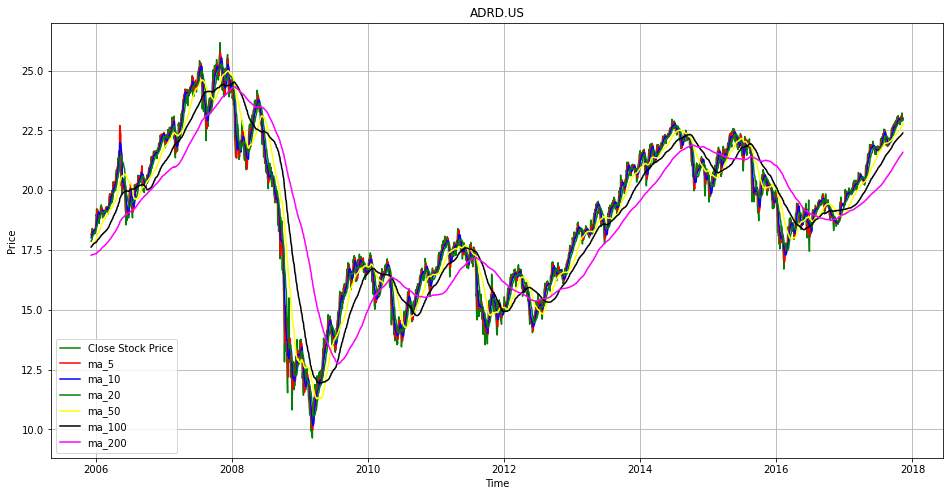

In [6]:
plt.figure(figsize=(16,8))
plt.plot(data['Close'], color = 'green', label = 'Close Stock Price')
plt.plot(data['Open_ma_5'], color = 'red', label = 'ma_5')
plt.plot(data['Open_ma_10'], color = 'blue', label = 'ma_10')
plt.plot(data['Open_ma_20'], color = 'green', label = 'ma_20')
plt.plot(data['Open_ma_50'], color = 'yellow', label = 'ma_50')
plt.plot(data['Open_ma_100'], color = 'black', label = 'ma_100')
plt.plot(data['Open_ma_200'], color = 'magenta', label = 'ma_200')
plt.title('ADRD.US')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Splitting trains set and test set

In [7]:

train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):int(len(data))]

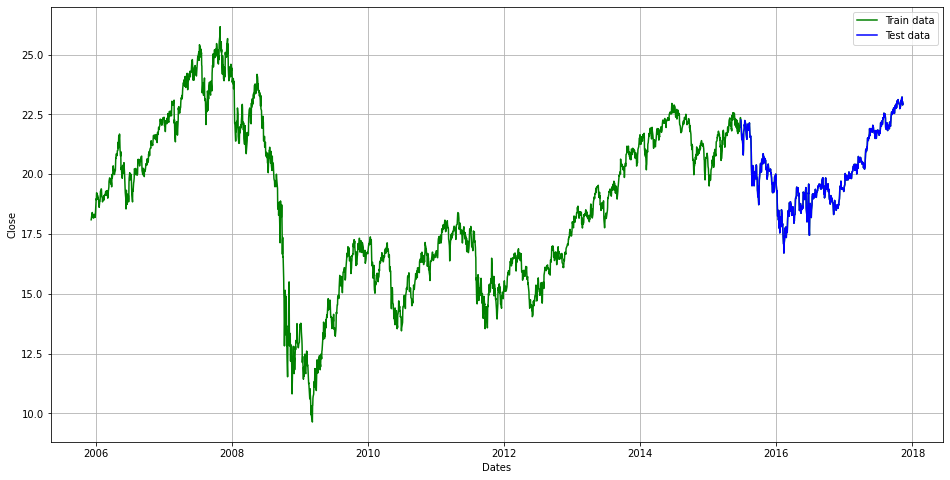

In [8]:

plt.figure(figsize=(16, 8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close')
plt.plot(data['Close'], 'green', label='Train data')
plt.plot(test_data['Close'], 'blue', label='Test data')
plt.legend()

In [ ]:
print("Train data shape--",train_data.shape)
print("Test data shape--",test_data.shape)

Train data shape-- (2389, 30)
Test data shape-- (598, 30)


In [9]:
get Open data
train = train_data.iloc[:, 0:1].values 
test = test_data.iloc[:, 0:1].values 

In [12]:

scaler = MinMaxScaler()# normalize the dataset
train_scaled = scaler.fit_transform(train)

In [13]:

timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) 
    y_train.append(train_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
print("X_train shape--",X_train.shape)
print("Y_train shape--",y_train.shape)

X_train shape-- (2382, 7)
Y_train shape-- (2382,)


In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  
print("X_train samples--",X_train.shape[0])
print("X_train timesteps--",X_train.shape[1])

X_train samples-- 2382
X_train timesteps-- 7


In [15]:
from numpy.random import seed
seed(2022)

# **Building the Model**

In [16]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.20))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Training set
history=model.fit(X_train, y_train, epochs = 40, batch_size = 32,validation_split=0.3)

model.summary()

Epoch 1/40
53/53 [==============================] - 11s 38ms/step - loss: 0.0670 - val_loss: 0.0042
Epoch 2/40
53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - val_loss: 0.0023
Epoch 3/40
53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 4/40
53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 6.9413e-04
Epoch 5/40
53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 6/40
53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - val_loss: 4.7298e-04
Epoch 7/40
53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 4.3610e-04
Epoch 8/40
53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 7.7339e-04
Epoch 9/40
53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - val_loss: 4.8820e-04
Epoch 10/40
53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - val_l

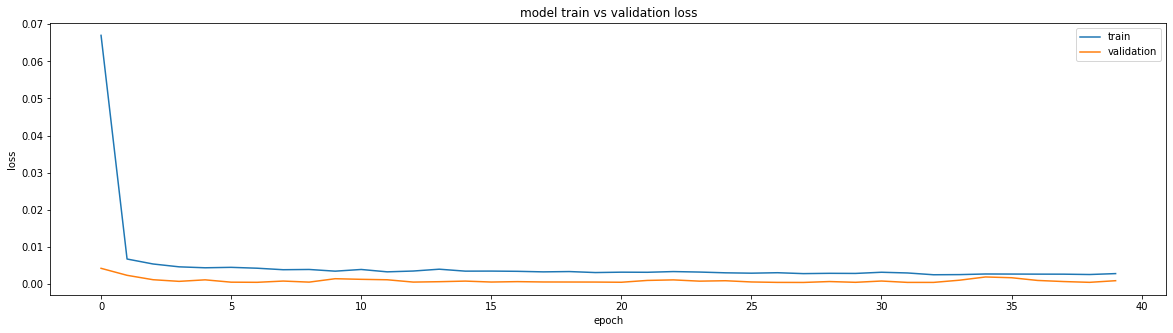

In [17]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(history.history[ 'loss' ]) 
plt.plot(history.history[ 'val_loss' ]) 
plt.title( 'model train vs validation loss' ) 
plt.ylabel( 'loss' ) 
plt.xlabel( 'epoch' ) 
plt.legend([ 'train' , 'validation' ], loc= 'upper right' ) 
plt.show()


### Train the model 

**Now making the predictions and visualising the results**

In [ ]:
test_data

,Open,High,Low,Close,Volume,OpenInt,Index,ma_5,ma_10,ma_20,ma_50,ma_100,ma_200
Date,,,,,,,,,,,,,
2016-12-15,113.55,114.89,113.40,113.99,44092267,0,32289,112.874,110.775,109.9895,110.7750,108.7598,103.000970
2016-12-16,114.63,114.66,113.82,114.14,39326480,0,32290,113.272,111.373,110.2860,110.8274,108.8986,103.073020
2016-12-19,113.97,115.51,113.92,114.80,26726101,0,32291,113.930,112.115,110.6105,110.8896,109.0305,103.153985
2016-12-20,114.90,115.63,114.84,115.11,19184853,0,32292,114.280,112.805,110.8680,110.9192,109.1667,103.240550
2016-12-21,114.96,115.53,114.94,115.21,21988995,0,32293,114.650,113.398,111.1270,110.9458,109.2860,103.327175
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-06,171.75,174.36,171.10,173.63,34901241,0,32513,169.548,164.557,160.6945,158.5822,154.4620,147.580500
2017-11-07,173.29,174.51,173.29,174.18,24424877,0,32514,170.698,166.321,161.6365,158.8480,154.7918,147.861050
2017-11-08,174.03,175.61,173.71,175.61,24451166,0,32515,172.562,168.297,162.6175,159.1136,155.0954,148.139350


In [18]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:, 3:4].values 
combine = pd.concat((train_data['Close'], test_data['Close']), axis = 0)
test_inputs = combine[len(combine) - len(test_data) -timesteps:].values

In [19]:
test_inputs  = test_inputs.reshape(-1, 1)
test_inputs = scaler.transform(test_inputs)


In [22]:
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# **Visualising the results**

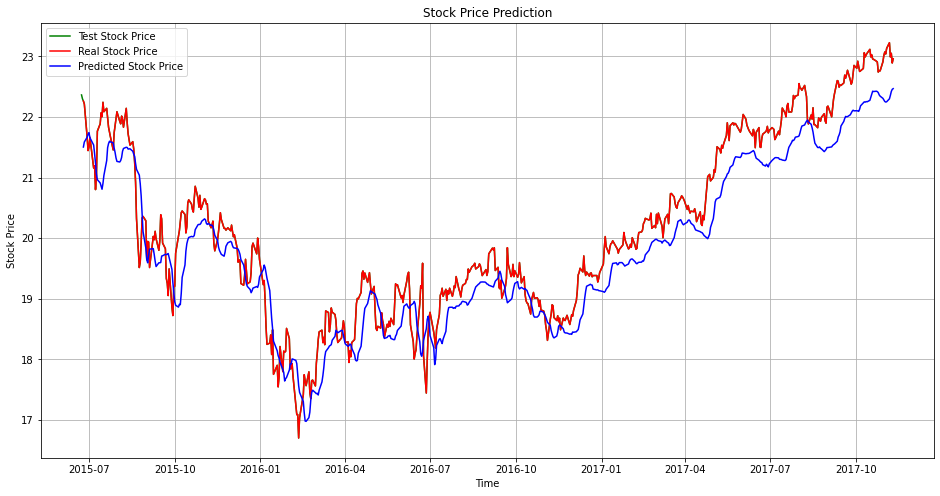

MSE: 0.27347404565230743
MAE: 0.4442924195356592
RMSE: 0.5229474597436222


In [23]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Close'].tail(600), color = 'green', label = 'Test Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))